In [30]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
from buffer import MultiModelActivationBuffer

from datasets import load_dataset
import torch as t

from nnsight import LanguageModel
from buffer import MultiModelActivationBuffer
from trainers.top_k import TopKTrainer, AutoEncoderTopK
from training import trainSAE
from einops import rearrange, einsum
import matplotlib.pyplot as plt
from tqdm import tqdm

device = "cuda:0"
dtype = t.bfloat16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
layer = 4
expansion = 32
num_tokens = int(100e6)
out_batch_size = 2048

submodule_list = []
model_list = []
for step in [1, 16, 128, 512, 1000, 2000, 4000, 8000, 16000, 32000, 64000, 143000]:
    model = LanguageModel(
        "EleutherAI/pythia-70m", 
        revision=f"step{step}", 
        trust_remote_code=False, 
        device_map=device,
        torch_dtype=dtype,
        )
    for x in model.parameters():
        x.requires_grad = False
    model_list.append(model)
    submodule_list.append(model.gpt_neox.layers[layer])
    
activation_dim = 512
dictionary_size = expansion * activation_dim

dataset = load_dataset(
    'Skylion007/openwebtext', 
    split='train', 
    streaming=True,
    trust_remote_code=True
    )

class CustomData():
    def __init__(self, dataset):
        self.data = iter(dataset)

    def __iter__(self):
        return self

    def __next__(self):
        return next(self.data)['text']

data = CustomData(dataset)

buffer = MultiModelActivationBuffer(
    data=data,
    model_list=model_list,
    submodule_list=submodule_list,
    d_submodule=activation_dim, # output dimension of the model component
    n_ctxs=128,  # you can set this higher or lower dependong on your available memory
    device=device,
    refresh_batch_size=128,
    out_batch_size=out_batch_size,
    remove_bos=True
)  # buffer will yield batches of tensors of dimension = submodule's output dimension

In [22]:
def concat(x):
    return rearrange(x, 'b n d -> b (n d)')
def unconcat(x):
    return rearrange(x, 'b (n d) -> b n d', n=len(model_list))

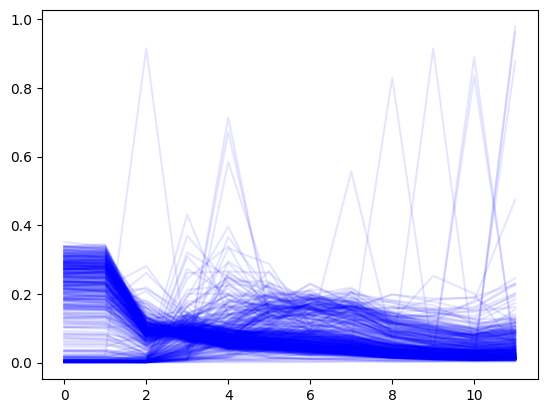

In [11]:
ae = AutoEncoderTopK.from_hf("jacobcd52/features_over_time", k=128, device=device)
dec = rearrange(ae.decoder.weight, "(n_models d) d_hid -> d_hid n_models d", n_models=len(model_list))
dec.shape
power = dec.pow(2).sum(-1)
power.shape
for i in range(500):
    plt.plot(power[i].detach().cpu(), color='blue', alpha=0.1)

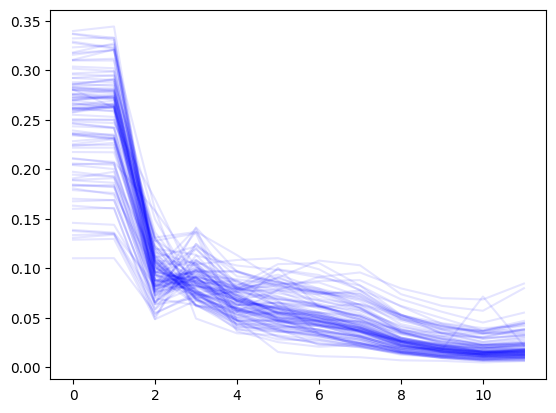

In [8]:
cpower = power.cumsum(-1)
# find the indices where the cumsum first exceeds 0.5
appear = (cpower > 0.2).float().argmax(-1)
is_dataset_feature = power.argmax(-1) < 2
is_dataset_feature.float().mean()
dataset_power = power[is_dataset_feature]
new_power = power[~is_dataset_feature]
for i in range(100):
    plt.plot(dataset_power[i].detach().cpu(), color='blue', alpha=0.1)

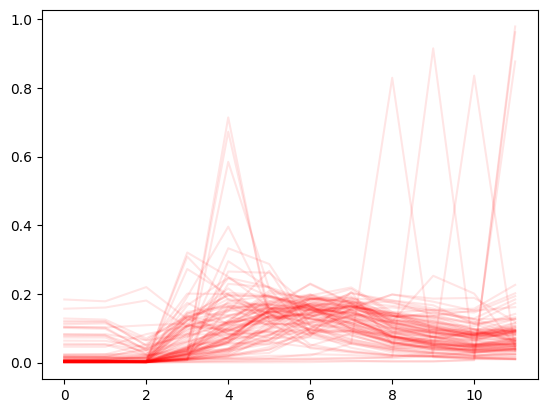

In [9]:
for i in range(100):
    plt.plot(new_power[i].detach().cpu(), color='red', alpha=0.1)

(0.0, 0.3)

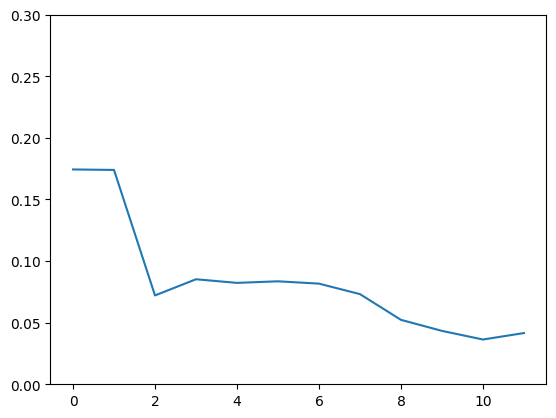

In [70]:
mean_power = power.mean(0)
plt.plot(mean_power.detach().cpu())
# set y lim
plt.ylim(0, 0.3)

In [ ]:
n_batches = 10
fvu = t.zeros(len(model_list)).cuda()
for _ in tqdm(range(n_batches)):
    x = next(buffer)

    # whiten
    x = unconcat(x)
    x -= ae.act_mean
    x /= ae.act_std
    x = concat(x)

    # pass through SAE
    x_hat = ae(x)

    # compute MSE per checkpoint
    e = unconcat(x - x_hat)
    fvu += e.var(dim=0).sum(-1) / x.var(dim=0).sum(-1)

fvu /= n_batches

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:02<00:00,  3.65it/s]


(0.0, 0.05)

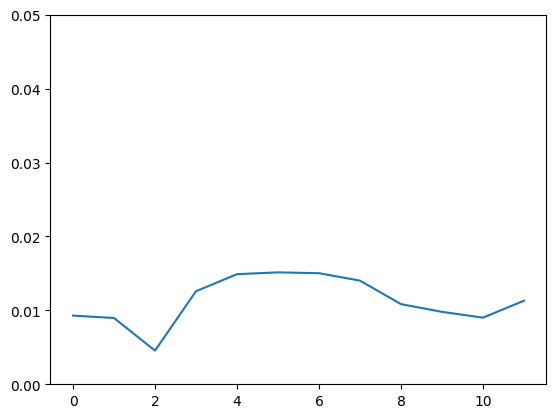

In [68]:
plt.plot(fvu.detach().cpu())
# set y range
plt.ylim(0, 0.05)